In [1]:
import numpy as np
from scipy import linalg
from math import *
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [2]:
import pyzbar.pyzbar as pyzbar
import cv2
import yaml
# 0.17m
length_ofedge=0.16
from collections import defaultdict


In [3]:
RUN_ON_CAR=True

from picar import front_wheels, back_wheels
from picar.SunFounder_PCA9685 import Servo
import picar
from time import sleep
picar.setup()

bw = back_wheels.Back_Wheels()
fw = front_wheels.Front_Wheels()
pan_servo = Servo.Servo(1)
tilt_servo = Servo.Servo(2)
picar.setup()
# - left
# + right
# to be measured directly on the picar
offset = 9
# pan_servo.offset = 10
# tilt_servo.offset = 0
initial_angle_fw=90+offset
bw.speed = 0
fw.turn(initial_angle_fw)
pan_servo.write(90)
tilt_servo.write(100)

# motor_speed = 70
# 70i*3=127cm, i= 1.27/210 m/s
# 70i=1.27/3=0.42333333333333334m/s
# 40i~100i=0.2419047619~0.60476190476 m/s
L=0.14
true_speed_unit=0.15/35
MAX_SPEED=100*true_speed_unit
MIN_SPEED=70*true_speed_unit
MIN_RADIAN=1.0/180*pi
MAX_TRUN_LEFT=(initial_angle_fw-120)*pi/180
MAX_TRUN_RIGHT=(initial_angle_fw-60)*pi/180

DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off


In [4]:
t=1
speed=60
angle=60


In [160]:
for i in range(9):
    bw.stop()
    fw.turn(angle)
    sleep(5)
    bw.speed=speed
    bw.backward()
    sleep(t)
    bw.stop()
# bw.speed=speed
# bw.backward()
# sleep(0.6)
# bw.stop()


In [150]:
bw.stop()
fw.turn(initial_angle_fw)
bw.speed=speed
bw.backward()
sleep(t)
bw.stop()


In [23]:
def read_and_distort(cap,mtx,dist):
    rat, frame = cap.read()
    height_ymax,width_xmax,channel=frame.shape
    if rat:
#         newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(width_xmax,height_ymax),1,(width_xmax,height_ymax))
        frame_distored = cv2.undistort(frame, mtx, dist, None)
    else:
        print 'read_and_distort: no image'
        return None
    return frame_distored,frame,height_ymax,width_xmax
def QR_scan_decode(img) : 
    # Find barcodes and QR codes
    
    decodedObjects = pyzbar.decode(img)
#     {name:locations}
    # Print results
    name_locations={int(obj.data):np.array(obj.location).astype(np.int32) for obj in decodedObjects if obj.type=='QRCODE'}
    return name_locations

def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    assert(isRotationMatrix(R))
     
    sy = sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = atan2(R[2,1] , R[2,2])
        y = atan2(-R[2,0], sy)
        z = atan2(R[1,0], R[0,0])
    else :
        x = atan2(-R[1,2], R[1,1])
        y = atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [4]:
def sample_and_avg(cap,mtx,dist, n):
    total_dict=defaultdict(list)
    for _ in range(n):
        frame,frame_undistorted,height_ymax,width_xmax=read_and_distort(cap,mtx,dist)
        name_locations = QR_scan_decode(frame)
        for lmk,lc in name_locations.items():
            total_dict[lmk].append(lc)
    for lmk,lc in total_dict.items():
        total_dict[lmk]=np.average(np.array(lc),axis=0).astype(np.int32)
    return total_dict,frame
    

In [5]:
def draw_data(frame,pts,lc,pos,angle,dis,bearing):
    cv2.polylines(frame,[pts],True,(255,0,0), 3)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for h in lc:
        cv2.putText(frame,str(h),tuple(h), font, 1,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(frame,'Pos of camera in lmk frame: '+str(pos[:,0]),(50,50), font, 0.5,(255,255,0),2,cv2.LINE_AA)
        cv2.putText(frame,'Z-Euler angle of object: '+str(angle),(50,100), font, 0.5,(255,255,0),2,cv2.LINE_AA)
        cv2.putText(frame,'Distance: '+str(dis),(50,150), font, 0.5,(255,255,0),2,cv2.LINE_AA)
        cv2.putText(frame,'Bearing wrt camera frame: '+str(bearing*180/pi)+'d',(50,200), font, 0.5,(255,255,0),2,cv2.LINE_AA)
    return frame

In [6]:
def QR_bearing_dis(cap,mtx,dist,mtx_fool,objp,sample_rate=50,draw=False):
    
    name_locations,frame=sample_and_avg(cap,mtx,dist, sample_rate)
#     if name_locations:
#         print name_locations
    observed=np.array(name_locations.keys())
    name_dis_bearing={}
    for lmk,lc in name_locations.items():
        center_line=303.790334392223
        qr_center=np.average(lc, axis=0)[0]
        x_dif=center_line-qr_center
        pts=lc.reshape(-1,1,2)
        ret,rvecs, tvecs = cv2.solvePnP(objp,lc.astype(np.float32), mtx_fool, np.array([]))
        Rt = np.zeros(shape=(3,3))
        cv2.Rodrigues(rvecs,Rt)
        R = Rt.transpose()
        pos=-R.dot(tvecs)
        euler_angles=rotationMatrixToEulerAngles(R)
        angle=[euler_angle*180/pi for euler_angle in euler_angles][1]
        dis=np.linalg.norm(pos)
        bearing=atan2(x_dif/625,dis)
        name_dis_bearing[lmk]=np.vstack([dis,bearing])
        if draw:
            draw_data(frame,pts,lc,pos,angle,dis,bearing)
    return name_dis_bearing,frame

In [65]:
while True:
    
#     frame,frame_undistorted,height_ymax,width_xmax=read_and_distort(cap,mtx,dist)
    
    
#     name_locations = QR_scan_decode(frame)

    

KeyboardInterrupt: 

lc

In [66]:
name_dis_bearing

{0: array([[ 0.50403349],
        [-0.58898149]])}

In [49]:
lc.dtype

dtype('float64')

In [27]:
np.average(np.array([lc,lc+20,lc-30]),axis=0)

array([[294.66666667, 211.66666667],
       [298.66666667, 406.66666667],
       [491.66666667, 404.66666667],
       [494.66666667, 205.66666667]])

In [40]:
cv2.polylines(frame,[pts],True,(255,0,0), 3)

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/drawing.cpp:2432: error: (-215) p.checkVector(2, 4) >= 0 in function polylines


In [44]:
frame.shape

(480, 640, 3)

In [614]:
# #  INITIALIZATION
# initialize map()
# time = 0
# #  TIME LOOP
# while (execution() == true) do:
    
#     for each robot in list of robots:
#         control = acquire control signal()
#     move robot(robot, control)
#     # LOOP SENSORS IN EACH ROBOT
#     for each sensor in robot−>list of sensors
#     raw = sensor−>acquire raw data()
#     # LOOP OBSERVATIONS IN EACH SENSOR
#     for each observation in sensor−>feasible observations()
#     # MEASURE LANDMARK AND CORRECT MAP
#     measurement = find known feature(raw, observation)
#     update map(robot, sensor, landmark, observation, measurement)
#     end
#     # DISCOVER NEW LANDMARKS WITH THE CURRENT SENSOR
#     measurement = detect new feature(raw)
#     # INITIALIZE LANDMARK
#     landmark = init new landmark(robot, sensor, measurement)
#     create new observation(sensor, landmark)
#     end
#     end
#     time ++
#     end

SyntaxError: invalid syntax (<ipython-input-614-fe9758ff01f4>, line 2)

In [8]:
def ctl_sig_mv(speed,angle,dt):
    """control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(angle)
    sleep(3)
    bw.speed=speed
    bw.backward()
    sleep(dt)
    bw.stop()
    sleep(3)


In [9]:
def cov2elli(x,P,n,NP):
    """ function [X,Y] = cov2elli(x,P,n,NP)
    COV2ELLI Ellipse contour from Gaussian mean and covariances matrix.
    [X,Y] = COV2ELLI(X0,P) returns X and Y coordinates of the contour of
    the 1?sigma ellipse of the Gaussian defined by mean X0 and covariances
    matrix P. The contour is defined by 16 points, thus both X and Y are
    16-vectors.
    
    [X,Y] = COV2ELLI(X0,P,n,NP) returns the n?sigma ellipse and defines the
    contour with NP points instead of the default 16 points.
    
    The ellipse can be plotted in a 2D graphic by just creating a line 
    with 'line(X,Y)' or 'plot(X,Y)'. """
    alpha = 2*pi/NP*np.array(range(NP+1)); # NP angle intervals for one turn
    circle = np.vstack([np.cos(alpha),np.sin(alpha)]); # the unit circle
    # SVD method, P = R*D*R' = R*d*d*R'
    R, D, Vh = np.linalg.svd(P)

    d = np.diag(np.sqrt(D));
    # n?sigma ellipse <? rotated 1?sigma ellipse <? aligned 1?sigma ellipse <? unit circle
    ellip = n * R .dot (d) .dot(circle);
    # output ready for plotting (X and Y line vectors)
    # print ellip
    X = x[0,0]+ellip[0:1,:];
    Y = x[1,0]+ellip[1:2,:];

    return X,Y

In [83]:
QR_quasi_scan(0,W,name_dis_bearing)

(array([[ 0.50403349],
        [-0.58898149]]), array([[-0.70710678, -0.70710678],
        [ 0.        , -1.        ]]))

In [27]:
def QR_real_scan (p,p_i,name_dis_bearing):
    """simulates the behavior of SCAN but with actual sensor
    function [y, Y_p] = scan (p)
    SCAN perform a range-and-bearing measure of a 2D point.
    
    In:
    p : point in sensor frame p = [p x ; p y]
    Out:
    y : measurement y = [range ; bearing]
    Y_p: Jacobian wrt p"""
#     p=W[:,p_i:p_i+1]
    px = p[0,0];
    py = p[1,0];
    y=name_dis_bearing[p_i]
    Y_p = np.vstack([
    np.hstack([px/sqrt(px**2+py**2) , py/sqrt(px**2+py**2)]),
    np.hstack([-py/(px**2*(py**2/px**2 + 1)), 1/(px*(py**2/px**2 + 1))]) ])
    return y,Y_p

In [28]:
def scan (p):
    """function [y, Y_p] = scan (p)
    SCAN perform a range-and-bearing measure of a 2D point.
    
    In:
    p : point in sensor frame p = [p x ; p y]
    Out:
    y : measurement y = [range ; bearing]
    Y_p: Jacobian wrt p"""

    px = p[0,0];
    py = p[1,0];
    d = sqrt(px**2+py**2);
    a = atan2(py,px);
    y = np.vstack([d,a])
    Y_p = np.vstack([
    np.hstack([px/sqrt(px**2+py**2) , py/sqrt(px**2+py**2)]),
    np.hstack([-py/(px**2*(py**2/px**2 + 1)), 1/(px*(py**2/px**2 + 1))]) ])
    return y,Y_p

In [12]:
def invScan(y):
    # function [p, P_y] = invScan(y)
    # INVSCAN Backproject a range−and−bearing measure into a 2D point.
    #
    # In:
    # y : range−and−bearing measurement y = [range ; bearing]
    # Out:
    # p : point in sensor frame p = [p x ; p y]
    # P y: Jacobian wrt y
    d = y[0,0];
    a = y[1,0];
    px = d*cos(a);
    py = d*sin(a);
    p = np.vstack([px,py]);
    P_y = np.vstack([np.hstack([cos(a) , -d*sin(a)]), np.hstack([sin(a) , d*cos(a)]) ]);
    return p, P_y

In [13]:
def fromFrame(F, pf):
    #     [pw, PW_f, PW_pf] = fromFrame(F, pf)
        # FROMFRAME Transform a point PF from local frame F to the global frame.
        # In:
        # F : reference frame F = [f x ; f y ; f alpha]
        # pf: point in frame F pf = [pf x ; pf y]
        # Out:
        # pw: point in global frame
        # PW_f: Jacobian wrt F
        # PW_pf: Jacobian wrt pf

    t = F[0:2];
    a = F[2,0];
    R = np.array([[cos(a),-sin(a)] , [sin(a),cos(a)]])


    pw = np.dot(R,pf) + np.tile(t, (1,pf.shape[1])); # Allow for multiple points
    px = pf[0,0];
    py = pf[1,0];
    PW_f = np.array([[ 1, 0, -py*cos(a)-px*sin(a)],[0,1,px*cos(a)-py*sin(a)]]);
    PW_pf = R;


    return pw, PW_f, PW_pf

#     function f()
#     ## Symbolic code below −− Generation and/or test of Jacobians
#     # − Enable 'cell mode' to use this section
#     # − Left−click once on the code below − the cell should turn yellow
#     # − Type ctrl+enter (Windows, Linux) or Cmd+enter (MacOSX) to execute
#     # − Check the Jacobian results in the Command Window.
#     syms x y a px py real
#     F = [x;y;a];
#     pf = [px;py];
#     pw = fromFrame(F,pf);
#     PW f = jacobian(pw,F)
#     PW pf = jacobian(pw,pf)
#     end

In [14]:
def toFrame(F , p):
    # function [pf, PF_f, PF_p] = toFrame(F , p)
    # # TOFRAME transform point P from global frame to frame F
    # #
    # # In:
    # # F : reference frame F = [f x ; f y ; f alpha]
    # # p : point in global frame p = [p x ; p y]
    # # Out:
    # # pf: point in frame F
    # # PF f: Jacobian wrt F
    # # PF p: Jacobian wrt p


    t = F[0:2];
    a = F[2,0];
    R = np.array([[cos(a),-sin(a)] , [sin(a),cos(a)]])
    pf = np.dot(R.T , (p - t))
     # Jacobians requested
    px = p[0,0]
    py = p[1,0]
    x = t[0,0]
    y = t[1,0]
    
    PF_f =np.array([[ -cos(a), -sin(a), cos(a)*(py - y) - sin(a)*(px - x)],[sin(a), -cos(a), - cos(a)*(px - x) - sin(a)*(py - y)]]);

    PF_p = R.T
    return pf, PF_f, PF_p


In [15]:
def QR_real_move(r,u,n,circle=True):
    if circle:
        
    

IndentationError: expected an indented block (<ipython-input-15-3946eb390192>, line 4)

In [16]:
def move(r, u, n):
# [ro, RO_r, RO_n] = move(r, u, n)
# MOVE Robot motion, with separated control and perturbation inputs.
#
# In:
# r: robot pose r = [x ; y ; alpha]
# u: control signal u = [d x ; d alpha]
# n: perturbation, additive to control signal
# Out:
# ro: updated robot pose
# RO r: Jacobian d(ro) / d(r)
# RO n: Jacobian d(ro) / d(n)

# r=R
# u=U
# n=np.zeros((2,1))
# print r,u,n

    a = r[2,0]

    dx = u[0,0] + n[0,0]
    da = u[1,0] + n[1,0]
    ao = a + da
    if ao > pi:
        ao = ao - 2*pi;
    if ao < -pi:
        ao = ao + 2*pi;
    # build position increment dp=[dx;dy], from control signal dx
    dp = np.vstack([dx,0])
    to, TO_r, TO_dt = fromFrame(r, dp)
    AO_a = 1;
    AO_da = 1;
    RO_r = np.vstack([TO_r,np.array([0,0,AO_a])])
    #     RO_r = [TO_r ; 0 0 AO_a];
    RO_n = np.vstack([np.hstack([TO_dt[:,[0]],np.zeros((2,1))]),np.array([0,AO_da])])
    #     RO_n = [TO_dt(:,1) np.zeros(2,1) ; 0 AO da];
    ro = np.vstack([to,ao])
    #     ro = [to;ao];
    return ro,RO_r, RO_n



In [30]:
def QR_real_observe(r,p,p_i,name_dis_bearing):
    """simulates the behavior of OBSERVE but use actual sensor measurement
    function [y, Y_r, Y_p] = observe(r, p)
    OBSERVE Transform a point P to robot frame and take a
    range−and−bearing measurement.
    
    In:
    r : robot frame r = [r_x ; r_y ; r_alpha]
    p : point in global frame p = [p_x ; p_y]
    Out:
    y: range−and−bearing measurement
    Y_r: Jacobian wrt r
    Y_p: Jacobian wrt p"""
    pr, PR_r, PR_p = toFrame(r, p);
    y,Y_pr=QR_real_scan(pr,p_i,name_dis_bearing)
    Y_r = np.dot(Y_pr, PR_r)
    Y_p = np.dot(Y_pr, PR_p)
    return y, Y_r, Y_p
    

In [31]:
def observe(r, p):
    """function [y, Y_r, Y_p] = observe(r, p)
    OBSERVE Transform a point P to robot frame and take a
    range−and−bearing measurement.
    
    In:
    r : robot frame r = [r_x ; r_y ; r_alpha]
    p : point in global frame p = [p_x ; p_y]
    Out:
    y: range−and−bearing measurement
    Y_r: Jacobian wrt r
    Y_p: Jacobian wrt p"""

    pr, PR_r, PR_p = toFrame(r, p);
    y, Y_pr = scan(pr);
    # The chain rule!
    Y_r = np.dot(Y_pr, PR_r)
    Y_p = np.dot(Y_pr, PR_p)
    return y, Y_r, Y_p

In [80]:
for i in observed:
    

IndentationError: expected an indented block (<ipython-input-80-61dad341e9d2>, line 2)

In [19]:
def invObserve(r, y):
    # function [p, P_r, P_y] = invObserve(r, y)
    # INVOBSERVE Backproject a range-and-bearing measurement and transform
    # to map frame.
    #
    # In:
    # r : robot frame r = [r x ; r y ; r alpha]
    # y : measurement y = [range ; bearing]
    # Out:
    # p : point in sensor frame
    # P_r: Jacobian wrt r
    # P_y: Jacobian wrt y


    P_r, PR_y = invScan(y);
    p, P_r, P_pr = fromFrame(r, P_r);
    # here the chain rule !
    P_y = P_pr .dot(PR_y);
    return p, P_r, P_y

<IPython.core.display.Javascript object>


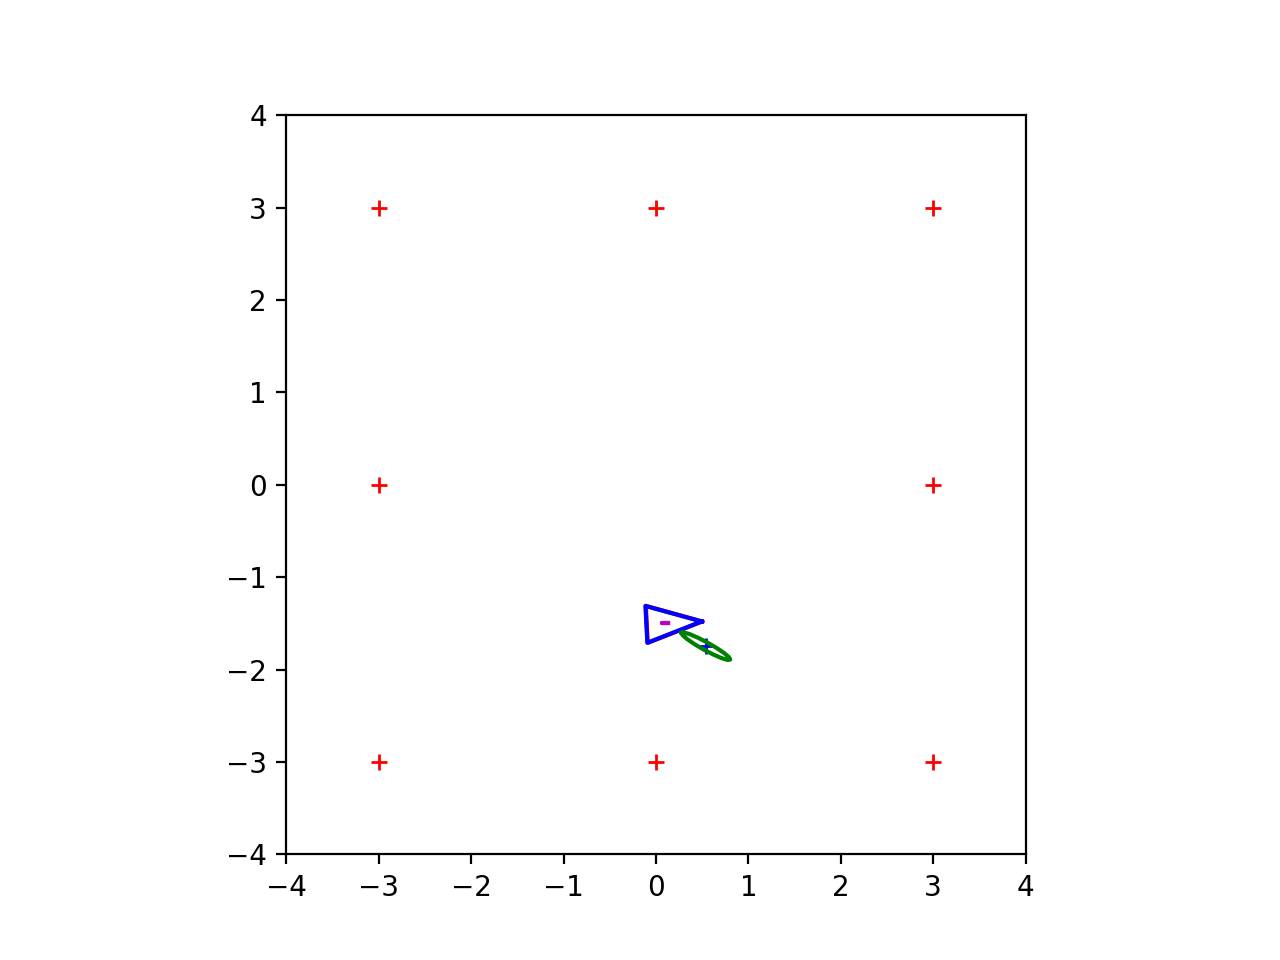

In [35]:
# # SLAM2D A 2D EKF−SLAM algorithm with simulation and graphics.
# #
# # HELP NOTES:
# # 1. The robot state is defined by [xr;yr;ar] with [xr;yr] the position
# # and [ar] the orientation angle in the plane.
# # 2. The landmark states are simply Li=[xi;yi]. There are a number of N
# # landmarks organized in a 2−by−N matrix W=[L1 L2 ... Ln]
# # so that Li = W(:,i).
# # 3. The control signal for the robot is U=[dx;da] where [dx] is a forward
# # motion and [da] is the angle of rotation.
# # 4. The motion perturbation is additive Gaussian noise n=[nx;na] with
# # covariance Q, which adds to the control signal.
# # 5. The measurements are range−and−bearing Yi=[di;ai], with [di] the
# # distance from the robot to landmark Li, and [ai] the bearing angle from
# # the robot's x−axis.
# # 6. The simulated variables are written in capital letters,
# # R: robot
# # W: set of landmarks or 'world'
# # Y: set of landmark measurements Y=[Y1 Y2 ... YN]
# # 7. The true map is [xr;yr;ar;x1;y1;x2;y2;x3;y3; ... ;xN;yN]
# # 8. The estimated map is Gaussian, defined by
# # x: mean of the map
# # P: covariances matrix of the map
# # 9. The estimated entities (robot and landmarks) are extracted from {x,P}
# # via pointers, denoted in small letters as follows:
# # r: pointer to robot state. r=[1,2,3]
# # l: pointer to landmark i. We have for example l=[4,5] if i=1,
# # l=[6,7] if i=2, and so on.
# # m: pointers to all used landmarks.
# # rl: pointers to robot and one landmark.
# # rm: pointers to robot and all landmarks (the currently used map).
# # Therefore: x(r) is the robot state,
# # x(l) is the state of landmark i
# # P(r,r) is the covariance of the robot
# # P(l,l) is the covariance of landmark i
# # P(r,l) is the cross−variance between robot and lmk i
# # P(rm,rm) is the current full covariance −− the rest is
# # unused.
# # NOTE: Pointers are always row−vectors of integers.
# # 10. Managing the map space is done through the variable mapspace.
# # mapspace is a logical vector the size of x. If mapspace(i) = false,
# # then location i is free. Oterwise mapspace(i) = true. Use it as
# # follows:
# # * query for n free spaces: s = find(mapspace==false, n);
# # * block positions indicated in vector s: mapspace(s) = true;
# # * liberate positions indicated in vector s: mapspace(s) = false;
# # 11. Managing the existing landmarks is done through the variable landmarks.
# # landmarks is a 2−by−N matrix of integers. l=landmarks(:,i) are the
# # pointers of landmark i in the state vector x, so that x(l) is the
# # state of landmark i. Use it as follows:
# # * query 1 free space for a new landmark: i = find(landmarks(1,:)==0,1)
# # * associate indices in vector s to landmark i: landmarks(:,i) = s
# # * liberate landmark i: landmarks(:,i) = 0;
# # 12. Graphics objects are Matlab 'handles'. See Matlab doc for information.
# # 13. Graphic objects include:
# # RG: simulated robot
# # WG: simulated set of landmarks
# # rG: estimated robot
# # reG: estimated robot ellipse
# # lG: estimated landmarks
# # leG: estimated landmark ellipses
# # (c) 2010, 2011, 2012 Joan Sola.

# I. INITIALIZE
# I.1 SIMULATOR −− use capital letters for variable names

objp = np.array([[-length_ofedge/2, -length_ofedge/2, 0.],
       [-length_ofedge/2, length_ofedge/2, 0.],
       [length_ofedge/2, length_ofedge/2, 0.],
       [length_ofedge/2, -length_ofedge/2, 0.]])
with open('calibration.yaml') as f:
    loadeddict = yaml.load(f)

mtx = np.array(loadeddict.get('camera_matrix'))
dist = np.array(loadeddict.get('dist_coeff'))
# axis = np.float32([[0.1,0,0], [0,0.1,0], [0,0,-0.1]]).reshape(-1,3)
mtx_fool=np.array([[625, 0.0, 303.790334392223],
                  [0.0, 625, 303.790334392223],
                  [0.0, 0.0, 1.0]])
cap = cv2.VideoCapture(1)


# W: set of external landmarks
W = np.array([[-3,-3,-3,0,0,3,3,3],[-3,0,3,-3,3,-3,0,3]]) # Type 'help cloister' for help
NameW=np.array(['l0','l1','l2','l3','l4','l5','l6','l7'])
# N: number of landmarks
# N = size(W,2);
# 9 land marks
N=W.shape[1]
# R: robot pose [x ; y ; alpha]
R = np.vstack([0,-1.5,0]);
# U: control [d x ; d alpha]
U = np.vstack([0.1 , 0.05]); # fixing advance and turn increments creates a circle
# Y: measurements of all landmarks
Y = np.zeros((2, N));
# I.2 ESTIMATOR
# Map: Gaussian {x,P}
# x: state vector's mean
x = np.zeros((R.size+W.size, 1));
# P: state vector's covariances matrix
P = np.zeros((x.size,x.size));

# System noise: Gaussian {0,Q}
q = np.vstack([.01,.02]) 
# amplitude or standard deviation
Q = np.diag(np.square(q[:,0])) # covariances matrix
# Measurement noise: Gaussian {0,S}
s = np.vstack([.1,1*pi/180]) # amplitude or standard deviation
S = np.diag(np.square(s[:,0])) # covariances matrix
# Map management
mapspace=np.full((1,x.size), False) # See Help Note #10 above.
# Landmarks management
landmarks = np.zeros((2, N),dtype=int) # See Help Note #11 above
# Place robot in map
r=np.nonzero(mapspace==False)[1][0:3] # set robot pointer
mapspace[:,r]=True # block map positions
x[r,:] = R # initialize robot states
P[np.ix_(r,r)]=0 # initialize robot covariance


# I.3 GRAPHICS −− use the variable names of simulated and estimated
# variables, followed by a capital G to indicate 'graphics'.
# NOTE: the graphics code is long but absolutely necessary.
# Set figure and axes for Map
fig, ax = plt.subplots()

# ax.axis([-5,5,-5,5]) # set axes limits
# ax.axis('square') # set 1:1 aspect ratio

# Simulated World −− set of all landmarks, red crosses
WG=Line2D(W[0,:],W[1,:],marker='+',color='r',linestyle='None')
ax.add_line(WG)
# WG=plt.plot(W[0,:],W[1,:],marker='+',color='r',linestyle='None')

# Simulated robot, red triangle
Rshape0 = 0.2*np.array([[2,-1,-1,2],[0,1,-1,0]]) # a triangle at the origin
Rshape,_,_ = fromFrame(R, Rshape0); # a triangle at the robot pose
RG=Line2D(Rshape[0,:],Rshape[1,:],color='r',linestyle='-')
ax.add_line(RG)
# RG=plt.plot(Rshape[0,:],Rshape[1,:],color='r')

# Estimated robot, blue triangle
rG = Line2D(Rshape[0,:],Rshape[1,:],color='b',linestyle='-')
ax.add_line(rG)
# rG = plt.plot(Rshape[0,:],Rshape[1,:],color='b')

# Estimated robot ellipse, magenta
# reG = plt.plot([],[],color='m')
reG = Line2D([],[],color='m',linestyle='-')
ax.add_line(reG)
# Estimated landmark means, blue crosses
lG = Line2D([],[],marker='+',color='b',linestyle='None')
ax.add_line(lG)
# lG = plt.plot([],[],marker='+',color='b',linestyle='None')

# Estimated landmark ellipses, green
leG = []
for i in range(N):
    leG.append(Line2D([],[],color='g',linestyle='-'))
#     leG += plt.plot([],[],color='g')
    ax.add_line(leG[i])
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')

In [21]:
cap

<VideoCapture 0x10e942ef0>

In [19]:
landmarks[:, i:i+1].T[0,:]

array([13, 14])

In [ ]:
observed=['landmark1','landmark2','landmark5',...]


In [89]:
name_dis_bearing[0]

array([[ 0.50403349],
       [-0.58898149]])

In [88]:
landmarks

array([[0, 5, 0, 0, 0, 0, 0, 3],
       [0, 6, 0, 0, 0, 0, 0, 4]])

In [87]:
x

array([[ 0.21827894],
       [-1.49535924],
       [ 0.09672257],
       [ 3.01277808],
       [ 2.92692265],
       [-2.95522753],
       [-0.01159417],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [96]:
mapspace

array([[ True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False]])

In [92]:
np.random.randint(lids.size)

0

In [95]:
np.nonzero(mapspace==False)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18]))

In [36]:
# II. TEMPORAL LOOP
for t in range(1):

    # II.1 SIMULATOR
    # a. motion
    n = q * np.random.randn(2,1); # perturbation vector
    R,_,_ = move(R, U, np.zeros((2,1)) ); # we will perturb the estimator
    # instead of the simulator
    # b. observations
    
    
#     for i in range(N):# i: landmark index  
#         v = s * np.random.randn(2,1); # measurement noise
#         Y[:,i:i+1] = observe(R, W[:,i:i+1])[0] + v;
    
    
        
        
    # II.2 ESTIMATOR
    # a. create dynamic map pointers to be used hereafter
    m = landmarks[landmarks!=0].T; # all pointers to landmarks
    rm = np.hstack([r , m]) # all used states: robot and landmarks
    # ( also OK is rm = find(mapspace); )
    # b. Prediction −− robot motion
    
#     ctl_sig_mv(speed,angle,dt) #actual control sent to the robot
    name_dis_bearing,frame=QR_bearing_dis(cap,mtx,dist,mtx_fool,objp,sample_rate=50,draw=True)
    observed=name_dis_bearing.keys()
    cv2.imshow("Results", frame)
    cv2.waitKey(1)
    x[r], R_r, R_n = move(x[r], U, n); # Estimator perturbed with n
    
    P[np.ix_(r,m)] = R_r.dot(P[np.ix_(r,m)]); # See PDF notes 'SLAM course.pdf'
    P[np.ix_(m,r)] = P[np.ix_(r,m)].T;
    P[np.ix_(r,r)] = R_r.dot(P[np.ix_(r,r)]).dot(R_r.T) + R_n.dot(Q).dot(R_n.T);
    # c. Landmark correction −− known landmarks
    lids = np.nonzero( landmarks[0,:])[0]; # returns all indices of existing landmarks
    lids=np.intersect1d(observed,lids)
    # All observed existing landmarks     
    for i in lids:
        # expectation: Gaussian {e,E}
        l = landmarks[:, i:i+1].T[0,:]; # landmark pointer
        e, E_r, E_l = observe(x[r], x[l] ); # this is h(x) in EKF
#         e, E_r, E_l=QR_real_observe(x[r], x[l],i,name_dis_bearing)
    
        rl = np.hstack([r , l]); # pointers to robot and lmk.
        E_rl = np.hstack([E_r , E_l]); # expectation Jacobian
        E = E_rl .dot( P[np.ix_(rl, rl)]) .dot( E_rl.T);
        # measurement of landmark i
        Yi= name_dis_bearing[i]
#         Yi = Y[:, i:i+1];
        # innovation: Gaussian {z,Z}
        z = Yi - e; # this is z = y - h(x) in EKF
        # we need values around zero for angles:
        if z[1,0] > pi:
            z[1,0] = z[1,0] - 2*pi;
        if z[1,0] < -pi:
            z[1,0] = z[1,0] + 2*pi;
        Z = S + E;
        # Individual compatibility check at Mahalanobis distance of 3-sigma
        # (See appendix of documentation file 'SLAM course.pdf')
        if (z.T).dot(np.linalg.inv(Z)).dot(z) < 9:
            # Kalman gain
            K = P[np.ix_(rm, rl)] .dot( E_rl.T) .dot( np.linalg.inv(Z)); # this is K = P*H'*Z^-1 in EKF
            # map update (use pointer rm)
            x[rm] = x[rm] + K.dot(z);
            P[np.ix_(rm,rm)] = P[np.ix_(rm,rm)] - K.dot(Z).dot(K.T);


    # d. Landmark Initialization −− one new landmark only at each iteration
    lids = np.nonzero(landmarks[0,:]==0)[0]; # all non−initialized landmarks
#     should be all observed-non-initialized landmarks
    lids=np.intersect1d(observed,lids)
    if lids.size: # there are still landmarks to initialize
#         i=4
        for i in lids:
#         i = lids[np.random.randint(lids.size)]; # pick one landmark randomly, its index is i
            l = np.nonzero(mapspace==False)[1][0:2]; # pointer of the new landmark in the map
            if l.size:# there is still space in the map
                mapspace[0,l] = True; # block map space
                landmarks[:,i:i+1] = np.vstack(l); # store landmark pointers
                # measurement
#                 Yi = Y[:,i:i+1];
                Yi= name_dis_bearing[i]
                # initialization
                x[l], L_r, L_y = invObserve(x[r], Yi);
                P[np.ix_(l,rm)] = L_r.dot(P[np.ix_(r,rm)]);
                P[np.ix_(rm,l)] = P[np.ix_(l,rm)].T;
                P[np.ix_(l,l)] = L_r.dot(P[np.ix_(r,r)]).dot(L_r.T) + L_y.dot(S).dot(L_y.T);


    # II.3 GRAPHICS
    # Simulated robot
    Rshape,_,_ = fromFrame(R, Rshape0);
    RG.set_data(Rshape[0,:],Rshape[1,:])

    # Estimated robot
    Rshape,_,_= fromFrame(x[r], Rshape0);
    rG.set_data(Rshape[0,:],Rshape[1,:])

    # Estimated robot ellipse
    re = x[r[0:2]]; # robot position mean
    RE = P[np.ix_(r[0:2],r[0:2])]; # robot position covariance
    xx,yy = cov2elli(re,RE,3,16); # x− and y− coordinates of contour
    reG.set_data(xx[0],yy[0])
    # Estimated landmarks
    lids = np.nonzero(landmarks[0,:])[0]; # all indices of mapped landmarks
    lx = x[landmarks[0,lids]]; # all x−coordinates
    ly = x[landmarks[1,lids]]; # all y−coordinates
    lG.set_data(lx,ly)

    # Estimated landmark ellipses −− one per landmark
    for i in lids:
        l = landmarks[:,i];
        le = x[l];
        LE = P[np.ix_(l,l)];
        xx,yy = cov2elli(le,LE,3,16);
        leG[i].set_data(xx[0],yy[0])
    fig.canvas.draw()
#     fig.canvas.flush_events()
    

In [105]:
cv2.imshow(frame)

TypeError: Required argument 'mat' (pos 2) not found

In [37]:
x

array([[ 0.09572129],
       [-1.5       ],
       [ 0.05340827],
       [ 0.53904469],
       [-1.7468312 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])